# What is IForest behavior according to the dataset dimension size?

## Test with multivariate dataset where anomalies are only in 1 dimension

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib.mlab import frange
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from imblearn.metrics import specificity_score
from imblearn.metrics import sensitivity_score
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from imblearn.metrics import specificity_score

Using TensorFlow backend.


## Generals settings

In [2]:
datasets_path = '/Users/thesard/Doctorat/These2018/ISEP/Developpements/AnacondaWorkSpace/LearningPython/datasets/'

## Chargement du jeu de données

Le jeu de données artificiel généré suivant une distribution gaussienne.
Il s'agit d'un jeu de données univarié ou unidimensionnel contenant des données normales et anormales.
Les données normales suivent une distribution gaussienne de paramètres mu = 0 et sigma = 1.
Les données anormales suivent une distribution gaussienne de paramètres mu = 5 et de sigma = 1.

In [20]:
dataset_path = datasets_path+"synthetic_full_random_data/synthetic_full_random_data_2019-12-17 13:16:20.514378.csv"
dataset_brut = pd.read_csv(dataset_path, header=None, index_col=None)
#dataset_brut = dataset_brut.drop([0])
dataset_number_dimension = len(dataset_brut.columns)
if dataset_number_dimension-2 == 0:
    X_brut_brut = dataset_brut[0]
elif dataset_number_dimension-2 > 0:
    x_dimensions = []
    for i in range(dataset_number_dimension-1):
        x_dimensions.append(i)
    X_brut_brut = dataset_brut[x_dimensions]
    #X_brut_brut = dataset_brut[[0,1,2]]
else:
    print("There is an error in the dataset you uploaded. It have to have at least 2 columns.")
X_brut = pd.DataFrame(X_brut_brut)
y_brut = dataset_brut[dataset_number_dimension-1]
#y_brut = pd.DataFrame(y_brut_brut)
X_brut

,0,1,2,3,4,5,6
0,age,Salary (in €),sexe,is_pregnant,is_parent,weight (in Kg),height (in Cm)
1,31,14219,0,0,1,74,180
2,63,13987,0,0,0,89,197
3,94,30171,1,0,0,85,189
4,29,30008,1,0,1,76,198
5,65,6223,1,0,1,75,181
6,65,33182,0,0,0,73,182
7,99,35856,1,0,1,72,180
8,3,0,1,0,0,18,86
9,77,35259,0,0,0,78,180


In [21]:
X_brut = X_brut.drop([0])
y_brut = y_brut.drop([0])

In [22]:
X_brut.describe()

,0,1,2,3,4,5,6
count,1500,1500,1500,1500,1500,1500,1500
unique,116,1224,2,2,2,93,120
top,71,0,1,0,0,78,197
freq,23,253,751,1120,856,60,60


In [23]:
X_brut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 1 to 1500
Data columns (total 7 columns):
0    1500 non-null object
1    1500 non-null object
2    1500 non-null object
3    1500 non-null object
4    1500 non-null object
5    1500 non-null object
6    1500 non-null object
dtypes: object(7)
memory usage: 93.8+ KB


## Transformation de la classe à expliquer

L'objectif ici est de remplacer les "0" par -1 et les "1" par 1 afin de faire les matrices de confusion avec la fonction dédiée de scikit-learn.

In [24]:
y_transform = y_brut
y_transform = np.where(y_transform=='0',-1,1)
y_transform

array([1, 1, 1, ..., 1, 1, 1])

## Execution of IForest on the dataset to see the high performance possible

In [25]:
specificities =[]
roc_aucs = []
for i in range(5):
    # Instanciation, fit and predict on Shuttle
    GENE_func_IF = IsolationForest(behaviour="new")
    GENE_func_IF.fit(X_brut)
    GENE_y_pred_IF = GENE_func_IF.predict(X_brut)
    #print(GENE_y_pred_IF)
    # Calcul de l'aire sous la courbe ROC
    y_DF_IF = GENE_func_IF.decision_function(X_brut)

    # Matrice de confusion
    #ttn, tfp, tfn, ttp = confusion_matrix(y_transform_Shuttle, MS_y_pred_IF_Shuttle).ravel()
    print(confusion_matrix(y_transform, GENE_y_pred_IF))
    #ROC AUC
    roc_aucs.append(roc_auc_score(y_transform, y_DF_IF))
    # Specificity
    specificities.append(specificity_score(y_transform, GENE_y_pred_IF))
print("ROC AUC")
print(roc_aucs)
print("Specificities")
print(specificities)
min_roc_auc = max(roc_aucs)
print("min_roc_auc = "+str(min_roc_auc))

/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


[[  15    0]
 [ 135 1350]]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


[[  15    0]
 [ 135 1350]]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


[[  15    0]
 [ 135 1350]]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


[[  14    1]
 [ 136 1349]]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


[[  14    1]
 [ 136 1349]]
ROC AUC
[0.9866217732884399, 0.9920089786756453, 0.9874747474747475, 0.9791245791245792, 0.9802918069584736]
Specificities
[1.0, 1.0, 1.0, 0.9333333333333333, 0.9333333333333333]
min_roc_auc = 0.9920089786756453


In [26]:
roc_auc_IF = []
max_samples_IF = []

for j in range(5, len(X_brut), 5):
    print("max_samples = "+str(j))
    max_samples = j
    # Instanciation, fit and predict on Shuttle
    func_IF = IsolationForest(max_samples=max_samples, behaviour="new")
    func_IF.fit(X_brut)
    y_pred_IF = func_IF.predict(X_brut)

    # Calcul de l'aire sous la courbe ROC
    y_DF_IF = func_IF.decision_function(X_brut)

    auc_IF = roc_auc_score(y_transform, y_DF_IF)
    if auc_IF >= min_roc_auc:
        print("auc_IF = "+str(auc_IF))
        roc_auc_IF.append(auc_IF)
        max_samples_IF.append(j)

max_samples = 5


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 10


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 15


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 20


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 25


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 30


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 35


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 40


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 45


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 50


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 55


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 60


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 65


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 70


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 75


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 80


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 85


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 90


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 95


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 105


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 110


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 115


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 120


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 125


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 130


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 135


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 140


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 145


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 150


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 155


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 160


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 165


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 170


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 175


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 180


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 185


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 190


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 195


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 200


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 205


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 210


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 215


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 220


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 225


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 230


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 235


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 240


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 245


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 250


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 255


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 260


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 265


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9947923681257015
max_samples = 270


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 275


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9944781144781145
max_samples = 280


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 285


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 290


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 295


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 300


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 305


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 310


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 315


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 320


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 325


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 330


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 335


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 340


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9949270482603816
max_samples = 345


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 350


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 355


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 360


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.995016835016835
max_samples = 365


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 370


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 375


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 380


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 385


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 390


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 395


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 400


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 405


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9932210998877665
max_samples = 410


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9926374859708192
max_samples = 415


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 420


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 425


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 430


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 435


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 440


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 445


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 450


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 455


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 460


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9952861952861952
max_samples = 465


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9949719416386084
max_samples = 470


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9971268237934904
max_samples = 475


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 480


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9948372615039281
max_samples = 485


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 490


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9924579124579125
max_samples = 495


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 500


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 505


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9967227833894501
max_samples = 510


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 515


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9928619528619528
max_samples = 520


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.997351290684624
max_samples = 525


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9976206509539843
max_samples = 530


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9921885521885521
max_samples = 535


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9948372615039281
max_samples = 540


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9936700336700336
max_samples = 545


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9938496071829405
max_samples = 550


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9955555555555556
max_samples = 555


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 560


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 565


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9946576879910214
max_samples = 570


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 575


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.997351290684624
max_samples = 580


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9963636363636363
max_samples = 585


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9943883277216611
max_samples = 590


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 595


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9931762065095397
max_samples = 600


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9942087542087542
max_samples = 605


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 610


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 615


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9948372615039281
max_samples = 620


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9943434343434344
max_samples = 625


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9951066217732885
max_samples = 630


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9961840628507296
max_samples = 635


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9965432098765432
max_samples = 640


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9947025813692479
max_samples = 645


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9957351290684624
max_samples = 650


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9964534231200898
max_samples = 655


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9968125701459035
max_samples = 660


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9970370370370369
max_samples = 665


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9978900112233446
max_samples = 670


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9936700336700337
max_samples = 675


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 680


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9940291806958473
max_samples = 685


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9959595959595959
max_samples = 690


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9957800224466891
max_samples = 695


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9965881032547699
max_samples = 700


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9995061728395063
max_samples = 705


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9954657687991021
max_samples = 710


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9969472502805836
max_samples = 715


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9969472502805836
max_samples = 720


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9940291806958473
max_samples = 725


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 730


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 735


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 740


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9930415263748597
max_samples = 745


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9974410774410775
max_samples = 750


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9951066217732883
max_samples = 755


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9956902356902357
max_samples = 760


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9982491582491583
max_samples = 765


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9977104377104378
max_samples = 770


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9971268237934905
max_samples = 775


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9955555555555555
max_samples = 780


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9993265993265994
max_samples = 785


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9957800224466892
max_samples = 790


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9969472502805836
max_samples = 795


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.996902356902357
max_samples = 800


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9938047138047138
max_samples = 805


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9971268237934904
max_samples = 810


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9950617283950618
max_samples = 815


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9951066217732885
max_samples = 820


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9993714927048261
max_samples = 825


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.997665544332211
max_samples = 830


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9964983164983165
max_samples = 835


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 840


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9946127946127946
max_samples = 845


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9978451178451179
max_samples = 850


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9941189674523009
max_samples = 855


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.998428731762065
max_samples = 860


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9930415263748598
max_samples = 865


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9970819304152638
max_samples = 870


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9969472502805836
max_samples = 875


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9969472502805836
max_samples = 880


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9959147025813693
max_samples = 885


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9968125701459034
max_samples = 890


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9975757575757576
max_samples = 895


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9976206509539843
max_samples = 900


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9957351290684624
max_samples = 905


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9977553310886644
max_samples = 910


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9955106621773289
max_samples = 915


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9933557800224466
max_samples = 920


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9960942760942761
max_samples = 925


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9964983164983165
max_samples = 930


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9958249158249158
max_samples = 935


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9934455667789002
max_samples = 940


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9980246913580247
max_samples = 945


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9936700336700337
max_samples = 950


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9986531986531987
max_samples = 955


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9960044893378227
max_samples = 960


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9968125701459034
max_samples = 965


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9963187429854096
max_samples = 970


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9963187429854097
max_samples = 975


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9955555555555557
max_samples = 980


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9984736251402919
max_samples = 985


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9974859708193041
max_samples = 990


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9960493827160494
max_samples = 995


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9975757575757576
max_samples = 1000


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9964983164983165
max_samples = 1005


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9980695847362514
max_samples = 1010


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9947474747474747
max_samples = 1015


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9958698092031426
max_samples = 1020


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9963187429854097
max_samples = 1025


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9957351290684624
max_samples = 1030


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9973961840628507
max_samples = 1035


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9981144781144781
max_samples = 1040


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9969921436588104
max_samples = 1045


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9983838383838384
max_samples = 1050


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9972166105499439
max_samples = 1055


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9971717171717172
max_samples = 1060


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9980695847362514
max_samples = 1065


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9968125701459035
max_samples = 1070


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9963636363636365
max_samples = 1075


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9958698092031425
max_samples = 1080


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9954208754208754
max_samples = 1085


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9966329966329966
max_samples = 1090


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9965432098765432
max_samples = 1095


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9960044893378227
max_samples = 1100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9985634118967452
max_samples = 1105


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9975757575757577
max_samples = 1110


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9993265993265994
max_samples = 1115


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9980246913580249
max_samples = 1120


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9969921436588104
max_samples = 1125


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9948372615039281
max_samples = 1130


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9972166105499438
max_samples = 1135


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9991919191919192
max_samples = 1140


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9973063973063974
max_samples = 1145


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9995510662177329
max_samples = 1150


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9979349046015713
max_samples = 1155


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9962738496071829
max_samples = 1160


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9967676767676767
max_samples = 1165


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9966329966329966
max_samples = 1170


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9990123456790123
max_samples = 1175


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.999236812570146
max_samples = 1180


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9959147025813693
max_samples = 1185


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9956004489337822
max_samples = 1190


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9987878787878788
max_samples = 1195


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9972166105499439
max_samples = 1200


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9979349046015713
max_samples = 1205


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9981593714927048
max_samples = 1210


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9979797979797981
max_samples = 1215


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9975308641975309
max_samples = 1220


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9961840628507295
max_samples = 1225


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.997845117845118
max_samples = 1230


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9975308641975309
max_samples = 1235


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9973961840628508
max_samples = 1240


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9975757575757576
max_samples = 1245


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9991470258136925
max_samples = 1250


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9974410774410775
max_samples = 1255


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.997979797979798
max_samples = 1260


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9975308641975309
max_samples = 1265


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9983389450056117
max_samples = 1270


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9987429854096521
max_samples = 1275


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9973961840628507
max_samples = 1280


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9989674523007857
max_samples = 1285


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9993265993265994
max_samples = 1290


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9982042648709316
max_samples = 1295


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9978900112233446
max_samples = 1300


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9995510662177329
max_samples = 1305


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.994702581369248
max_samples = 1310


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.997665544332211
max_samples = 1315


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9986083052749719
max_samples = 1320


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.998294051627385
max_samples = 1325


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9976206509539843
max_samples = 1330


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9974859708193041
max_samples = 1335


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9973961840628507
max_samples = 1340


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9971268237934905
max_samples = 1345


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9976206509539843
max_samples = 1350


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9970819304152638
max_samples = 1355


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9986980920314255
max_samples = 1360


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.998608305274972
max_samples = 1365


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9983389450056117
max_samples = 1370


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9978002244668911
max_samples = 1375


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9985634118967452
max_samples = 1380


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9978002244668911
max_samples = 1385


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9962289562289562
max_samples = 1390


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9966329966329966
max_samples = 1395


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9982042648709315
max_samples = 1400


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9986531986531987
max_samples = 1405


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9985634118967452
max_samples = 1410


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9964983164983164
max_samples = 1415


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9978451178451179
max_samples = 1420


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9965432098765432
max_samples = 1425


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9985185185185186
max_samples = 1430


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9979797979797981
max_samples = 1435


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9986980920314255
max_samples = 1440


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9986083052749719
max_samples = 1445


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9977553310886644
max_samples = 1450


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9977553310886644
max_samples = 1455


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.998922558922559
max_samples = 1460


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.997665544332211
max_samples = 1465


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9995061728395062
max_samples = 1470


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.998922558922559
max_samples = 1475


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9964534231200898
max_samples = 1480


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9959147025813693
max_samples = 1485


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9965432098765432
max_samples = 1490


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.9987878787878788
max_samples = 1495


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


auc_IF = 0.999236812570146


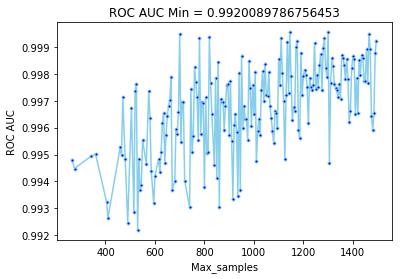

In [27]:
plt.plot(max_samples_IF, roc_auc_IF,  "b-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
plt.title("ROC AUC Min = "+str(min_roc_auc))
#plt.axis([0, 1, 0, 1])
plt.xlabel('Max_samples')
plt.ylabel('ROC AUC')
plt.show()

## Test avec LOF

In [28]:
from sklearn.neighbors import LocalOutlierFactor
for i in range(5):
    # Instanciation, fit and predict on Shuttle
    func_LOF = LocalOutlierFactor(novelty = True)
    func_LOF.fit(X_brut)
    y_pred_LOF = func_LOF.predict(X_brut)
    # Calcul de l'aire sous la courbe ROC
    y_DF_LOF = func_LOF.decision_function(X_brut)

    # Matrice de confusion
    #ttn, tfp, tfn, ttp = confusion_matrix(y_transform_Shuttle, MS_y_pred_IF_Shuttle).ravel()
    print(confusion_matrix(y_transform, y_pred_LOF))

    print(roc_auc_score(y_transform, y_DF_LOF))

[[  10    5]
 [ 117 1368]]
0.8484848484848484
[[  10    5]
 [ 117 1368]]
0.8484848484848484
[[  10    5]
 [ 117 1368]]
0.8484848484848484
[[  10    5]
 [ 117 1368]]
0.8484848484848484
[[  10    5]
 [ 117 1368]]
0.8484848484848484


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl